# __Comparing regression models for selection__

### Pat Walters notes and Data source

We will be using the results from the [Validation of AMBER/GAFF for Relative Free Energy Calculations](https://chemrxiv.org/articles/Validation_of_AMBER_GAFF_for_Relative_Free_Energy_Calculations/7653434) article to determine different approaches to free energy calculations.

Additional information is on the [Practical Cheminformatics](http://practicalcheminformatics.blogspot.com/2019/02/some-thoughts-on-evaluating-predictive.html) blog


## Requirements for the notebook

!pip install pandas matplotlib seaborn numpy scipy scikit-learn


In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import math
from math import sqrt
from scipy.stats import norm, pearsonr
from sklearn.metrics import mean_squared_error
from collections import namedtuple

# Setting defaults

pd.options.display.float_format = '{:,.2f}'.format # Display numbers with 2 decimal places


In [53]:
# Read in data from xlsx file (Excel file)
xls_url = "https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/data/FEP_vs_GTI-dG-SI.xlsx"
df_dict = pd.read_excel(xls_url, sheet_name=None, header=None)

## Filtering data to get what we want. 
### Preferably download the dataset and look at the data in excel before sorting

## __Pat Walters notes:__
Now we can define a function that will grab the data from a particular sheet. 

In this case the data we want is in columns 15-17. We'll grab those columns and create a new dataframe with the columns labeled as Experimental Δ G, FEP Δ G, and TI Δ G. We will also include columns with the target and with the target concatenated with a sequential index. 

We're going to label the columns as Experimental_dG, etc. for convenience. The final row in columns 15-17 is the sum of the values in the column. We don't want this, so we'll use df = df.query("Experimental_dG > -20") to get rid of the sum row.

In [54]:
def get_data_from_excel(df_dict="df_dict", sheet_name="sheet_name", col_names=["Experimental_dG","FEP_dG","TI_dG"], col_range_1=0, col_range_2=0): 
    """
    Retrieves data from an Excel file and performs data preprocessing.

    Parameters:
    - df_dict (dict): A dictionary containing the Excel file data.
    - sheet_name (str): The name of the sheet in the Excel file to retrieve data from.
    - col_names (list): A list of column names to assign to the retrieved data.
    - col_range_1 (int): The starting index of the columns of interest.
    - col_range_2 (int): The ending index of the columns of interest.

    Returns:
    - df (DataFrame): The preprocessed data as a pandas DataFrame.
    """

    # Get data from excel
    df = df_dict[sheet_name]
    
    # choose columns of interest
    df = df[df.columns[col_range_1:col_range_2]]

    # rename columns
    df.columns = col_names 

    # remove columns with no data
    df = df.dropna()
    
    # remove last row which is the sum of the values
    df = df.query("Experimental_dG > -20")

    # add target and ID
    rows, _ = df.shape
    df.insert(0, "Target", [sheet_name] * rows)
    df.insert(1, "ID", [f"{sheet_name}_{x}" for x in range (0,rows)])

    return df


In [55]:
#Extracting data from excle
sheet_names = df_dict.keys()
big_df = pd.DataFrame(columns=["Target", "ID", "Experimental_dG", "FEP_dG", "TI_dG"])
for sheet in sheet_names:
    tmp_df = get_data_from_excel(df_dict, sheet, col_range_1=15, col_range_2=18)
    big_df = big_df.merge(tmp_df,how="outer") 

big_df.sort_values("Target", inplace=True)



In [56]:
big_df.head()

,Target,ID,Experimental_dG,FEP_dG,TI_dG
99,bace,bace_12,-8.53,-6.76,-8.27
117,bace,bace_30,-7.84,-7.40,-7.40
116,bace,bace_29,-9.01,-7.93,-7.80
115,bace,bace_28,-8.25,-7.01,-9.72
114,bace,bace_27,-9.10,-10.14,-10.16


In [57]:
# Saving the extracted FEP dataframe 
big_df.to_csv("./data/FEP_dataframe.csv",index=False)

## Reformatting the data for plotting

### Pat Walters notes
In order to make some of our plots we need to reshape the data so that "FEP_dG" and "TI_dG" are in one column. We can use the Pandas "melt" function to do this.

In [58]:
# Reformatting the data for plotting
# id_vars column names will remain the same in new dataframe
mdf = big_df.melt(id_vars=["Target","ID", "Experimental_dG"])

# The above step then takes the columns next to Experimental_dG and makes a column named variable with 
# the column names as the values in the rows and column named value with the values in the rows. 
# Now FEP_dG and TI_dG columns are merged

# Taking the FEP_dG vlaues in the column named variable ad removing the "_dG"
mdf["Dataset"] = mdf.Target + "_" + mdf.variable.str.replace("_dG","")

# Sort values by Dataset name variables
mdf.sort_values("Dataset", inplace=True)

# Listing columns
cols = list(mdf.columns)

# Renaming the value column to Predicted_dG
cols[4] = "Predicted_dG"
mdf.columns = cols

# Adding a column to to idicate if predicted data is FEP or TI so that we can make better looking plots.
# Can also use the variable column as well

mdf["Method"] = [x.replace("_dG","") for x in mdf.variable.values]

mdf

,Target,ID,Experimental_dG,variable,Predicted_dG,Dataset,Method
0,bace,bace_12,-8.53,FEP_dG,-6.76,bace_FEP,FEP
20,bace,bace_10,-9.69,FEP_dG,-9.38,bace_FEP,FEP
21,bace,bace_9,-8.72,FEP_dG,-8.73,bace_FEP,FEP
22,bace,bace_0,-8.83,FEP_dG,-8.82,bace_FEP,FEP
23,bace,bace_1,-9.11,FEP_dG,-8.90,bace_FEP,FEP
...,...,...,...,...,...,...,...
384,tyk2,tyk2_1,-9.78,TI_dG,-9.62,tyk2_TI,TI
383,tyk2,tyk2_2,-8.26,TI_dG,-8.62,tyk2_TI,TI
396,tyk2,tyk2_4,-9.56,TI_dG,-9.87,tyk2_TI,TI
388,tyk2,tyk2_7,-9.00,TI_dG,-9.74,tyk2_TI,TI


## Defining a function tomake some plots using Seaborn FacetGrid class.

### Pat Walters notes:

Using the Seaborn FacetGrid class to put plots side by side. 

Define a custom plotting function that plots Experimental  Δ G vs Predicted  Δ G. 

Put in lines at 2 kcal above and below the unity line. 

The only argument being passed is "skip_text" which tells the function whether to display the  𝑅2  for the correlation.

### Metric to be used for correlation:

Pearson correlation coefficient and p-value for testing non-correlation.

The Pearson correlation coefficient [1]_ measures the linear relationship between two datasets. Like other correlation coefficients, this one varies between -1 and +1 with 0 implying no correlation. Correlations of -1 or +1 imply an exact linear relationship. Positive correlations imply that as x increases, so does y. Negative correlations imply that as x increases, y decreases.


In [62]:
def draw_dG_facet(*args,**kwargs):
    skip_text = False
    if kwargs.get("skip_text"):
        kwargs.pop("skip_text")
        skip_text = True
    xlim, ylim = np.array([[-15,-4],[-15,-4]])
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=FutureWarning)
        ax = sns.scatterplot(x=args[0],y=args[1],**kwargs)
    r2 = pearsonr(args[0],args[1])[0]**2
    pad = 2
    if not skip_text:
        ax.text(-14,-6,f"$R^2$={r2:.2f}")
    ax.plot(xlim,ylim,linewidth=2, color='blue')
    ax.plot(xlim,ylim+pad,color="black",linestyle="--")
    ax.plot(xlim,ylim-pad,color="black",linestyle="--")
    ax.set(xlim=xlim,ylim=ylim)

### Try not to plot every target onto the same plot. Rather split up

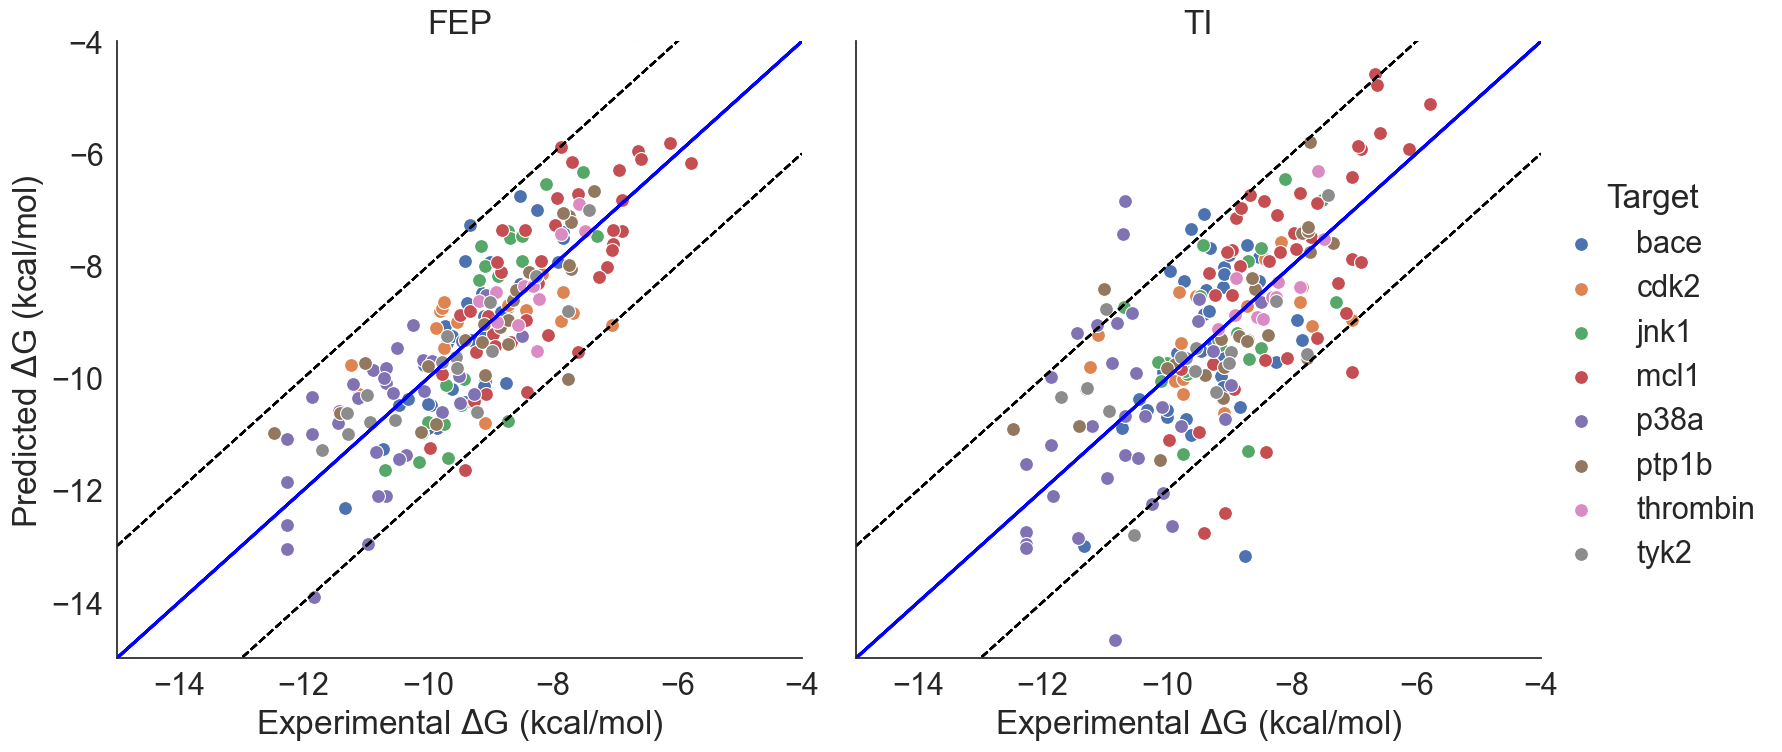

In [63]:
# Everything on the same plot
sns.set_theme(font_scale=2)
sns.set_style("white")
g = sns.FacetGrid(mdf,col="Method",hue="Target",col_wrap=2,height=8,legend_out=True)
g.map(draw_dG_facet,"Experimental_dG","Predicted_dG",skip_text=True,s=100)
_ = g.set_titles(col_template="{col_name}")
g.set_xlabels("Experimental $\Delta$G (kcal/mol)")
g.set_ylabels("Predicted $\Delta$G (kcal/mol)")
_ = g.add_legend()

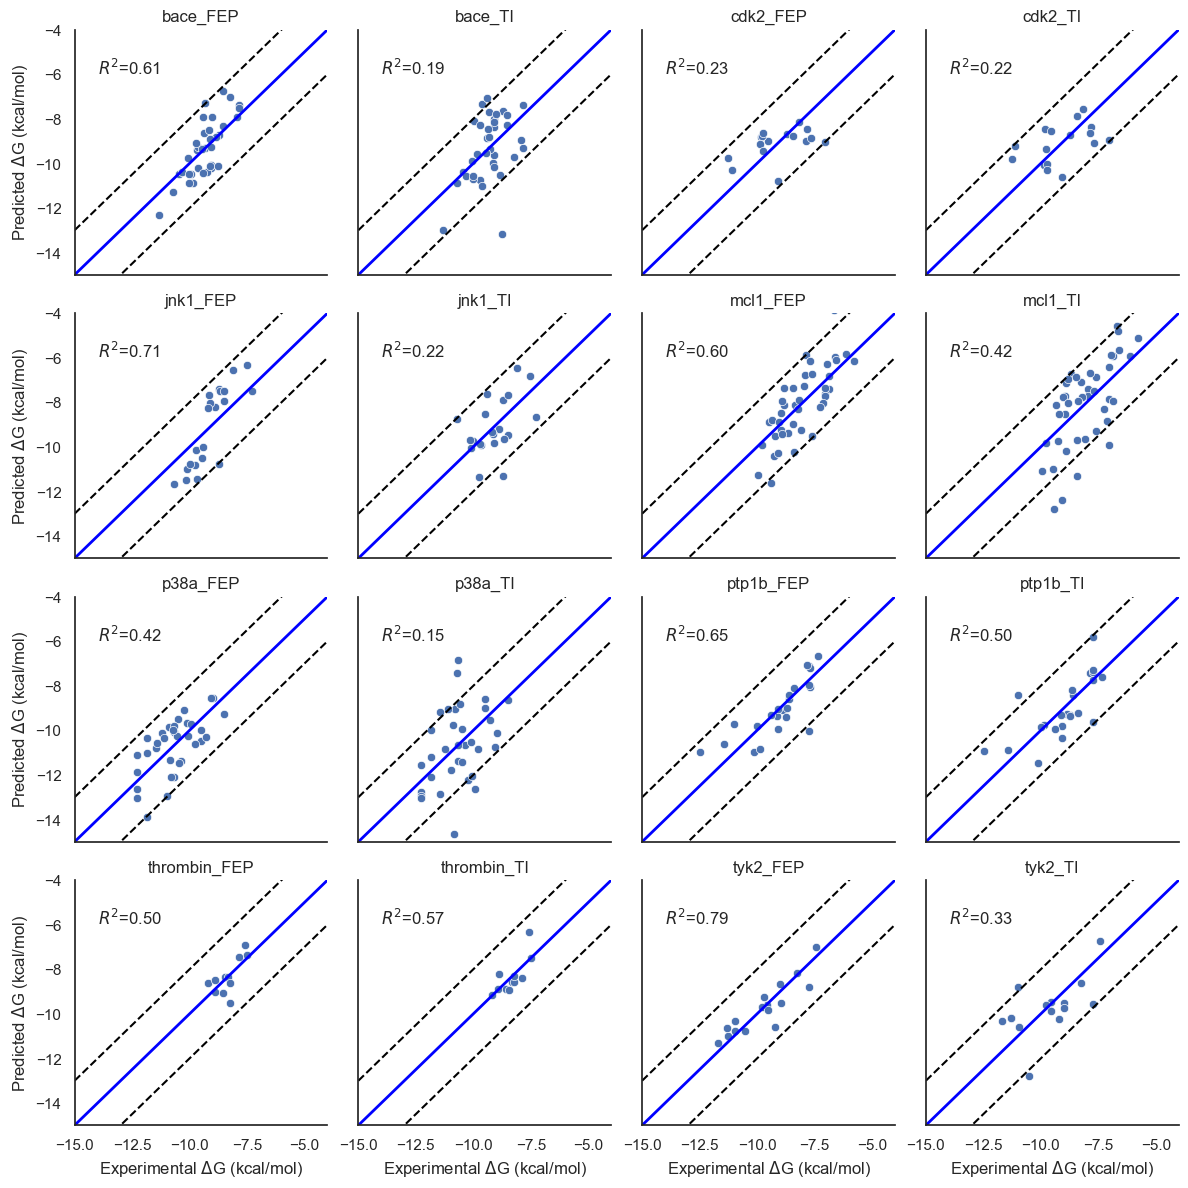

In [65]:
# Plotting the predicted vs experimental dG for each target and type of predicted dG
sns.set_theme(font_scale=1)
sns.set_style("white")
g = sns.FacetGrid(mdf,col="Dataset",col_wrap=4)
g.map(draw_dG_facet,"Experimental_dG","Predicted_dG")
_ = g.set_titles(col_template="{col_name}")
g.set_xlabels("Experimental $\Delta$G (kcal/mol)")
_= g.set_ylabels("Predicted $\Delta$G (kcal/mol)")

### Calculating the confidenece intervals for the pearson correlation coefficients

### Pat Walters notes
This was inspired by the following question https://stats.stackexchange.com/questions/18887

In [66]:
def pearson_confidence(r, number, interval=0.95):
    """
    Calculates the confidence interval for the Pearson correlation coefficient.

    Parameters:
    - r (float): The Pearson correlation coefficient.
    - number (int): The number of data points used to calculate the correlation coefficient.
    - interval (float, optional): The desired confidence interval (default is 0.95).

    Returns:
    - lower (float): The lower bound of the confidence interval.
    - upper (float): The upper bound of the confidence interval.
    """
    sdterr = 1.0 / math.sqrt(number - 3)
    interval = interval + (1 - interval) / 2
    z_score = norm.ppf(interval)
    delta = z_score * sdterr
    lower = math.tanh(math.atanh(r) - delta)
    upper = math.tanh(math.atanh(r) + delta)

    return lower, upper


In [82]:
# Calculating the Perason R for each target/method combination

# group by target
gb = big_df.groupby("Target")

# initiate results list
results = []

# loop over targets
for k,v in gb:
    number = len(v.Experimental_dG)

    r_FEP = pearsonr(v.Experimental_dG, v.FEP_dG)[0]    
    r_TI = pearsonr(v.Experimental_dG, v.TI_dG)[0]

    lb_FEP, ub_FEP = pearson_confidence(r_FEP, number)
    lb_TI, ub_TI = pearson_confidence(r_TI, number)

    results.append([k,len(v)]+[x for x in [lb_FEP,r_FEP,ub_FEP,lb_TI,r_TI,ub_TI]])
res_df = pd.DataFrame(results,columns=["Target","Num","FEP_LB","FEP Correlation","FEP_UB","TI_LB","TI Correlation","TI_UB"])

In [83]:
# Need to reshape the data using melt for plotting 

melt_res_df = res_df[["Target", "FEP Correlation", "TI Correlation"]].melt(id_vars="Target")
melt_res_df.sort_values("Target", inplace=True)

melt_res_df

,Target,variable,value
0,bace,FEP Correlation,0.78
8,bace,TI Correlation,0.43
1,cdk2,FEP Correlation,0.48
9,cdk2,TI Correlation,0.47
2,jnk1,FEP Correlation,0.84
10,jnk1,TI Correlation,0.47
3,mcl1,FEP Correlation,0.77
11,mcl1,TI Correlation,0.65
4,p38a,FEP Correlation,0.65
12,p38a,TI Correlation,0.38


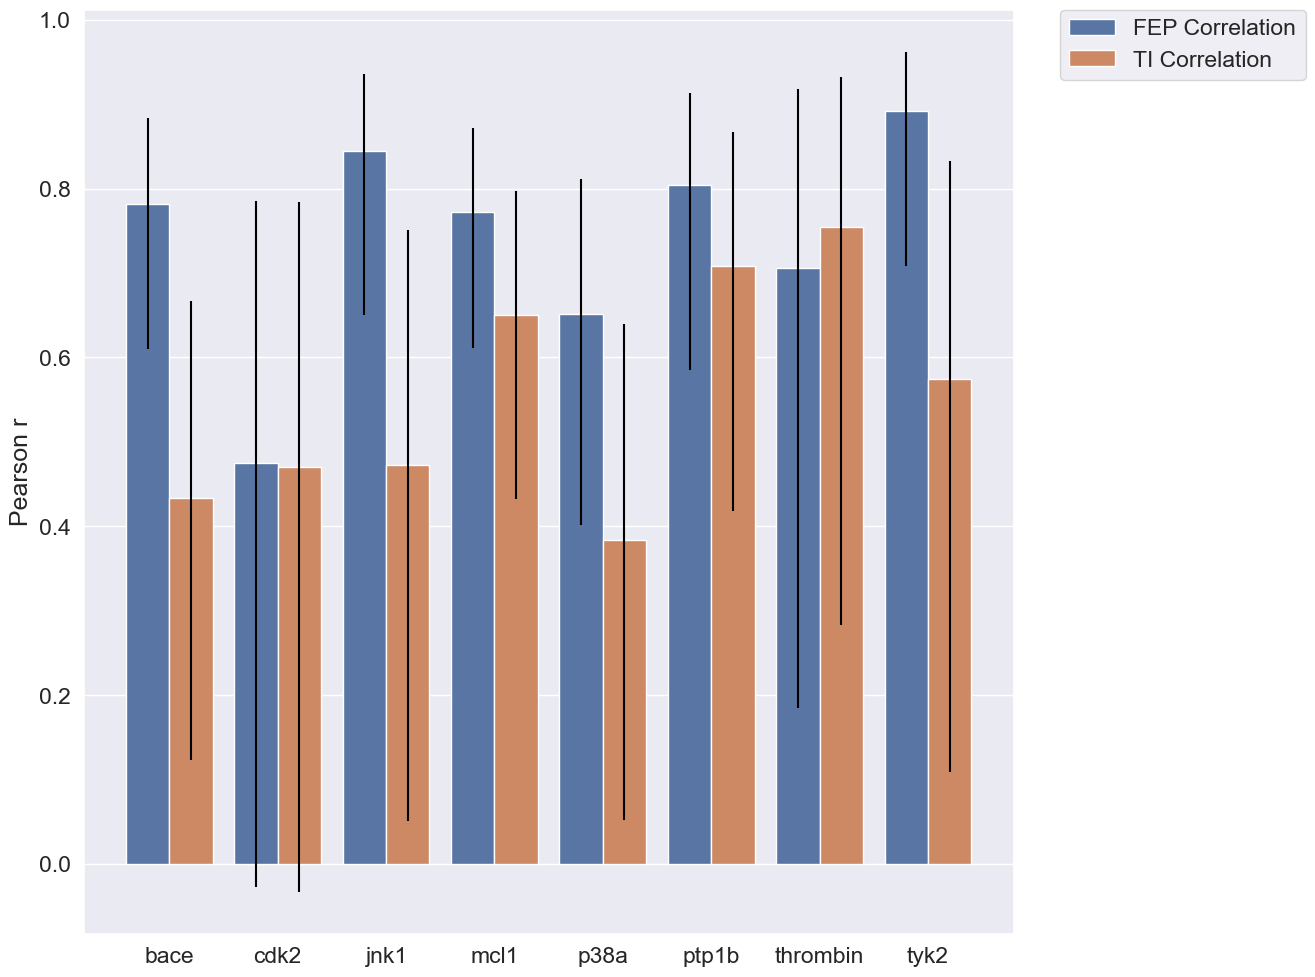

In [84]:
# Plotting Correlations with the error bars
sns.set_theme(rc={'figure.figsize':(12,12)},font_scale=1.5)
ax = sns.barplot(x="Target",y="value",hue="variable",data=melt_res_df)
x_pos = np.arange(8)-0.2
y_val = res_df["FEP Correlation"]
lb = y_val - res_df.FEP_LB
ub = res_df.FEP_UB - y_val
ax.errorbar(x_pos,y_val,yerr=[lb,ub],fmt="none",capsize=0,color='black')
x_pos = np.arange(8)+0.2
y_val = res_df["TI Correlation"]
lb = y_val - res_df.TI_LB
ub = res_df.TI_UB - y_val
a = ax.errorbar(x_pos,y_val,yerr=[lb,ub],fmt="none",capsize=0,color='black')
handles, labels = ax.get_legend_handles_labels()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., handles=handles[0:2], labels=labels[0:2])
_ = ax.set(xlabel='', ylabel="Pearson r")

## Pat Walters notes

#### Calculating the Effect Size
As [Anthony Nicholls](https://link.springer.com/article/10.1007/s10822-016-9904-5) points out, when we have a data set like this with dependent errors, the fact that error bars overlap does not necessarily imply that the methods are equivalent.  However, we can use the mean of differences / std deviation of the differences to calculate [Cohen's d](https://machinelearningmastery.com/effect-size-measures-in-python/), which measures the effect size. Cohen’s d measures the difference between the mean from two Gaussian-distributed variables. It is a standard score that summarizes the difference in terms of the number of standard deviations. Because the score is standardized, there is a table for the interpretation of the result, summarized as:

- Small Effect Size: d=0.20
- Medium Effect Size: d=0.50
- Large Effect Size: d=0.80

In [90]:
delta = res_df["FEP Correlation"].values-res_df["TI Correlation"].values
np.mean(delta)/np.std(delta)

1.2137416942335344

We get a Cohen's d of 1.2, which is a very large effect size.
We can define a function to convert d to an approximate probability between 0 and 1.

Results:

So for the 8 datasets we examined, FEP should outperform TI in 8 of 10 cases. To look at this visually, let's plot a kernel density estimate for the Pearson r distributions.

In [91]:
def d_to_probability(d):
    return 0.25 * abs(d) + 0.5 
d_to_probability(-1.2)

0.8

/Users/luke_zondagh_m1/Softwares/miniforge3/envs/PatWalters_tutorial/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/luke_zondagh_m1/Softwares/miniforge3/envs/PatWalters_tutorial/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


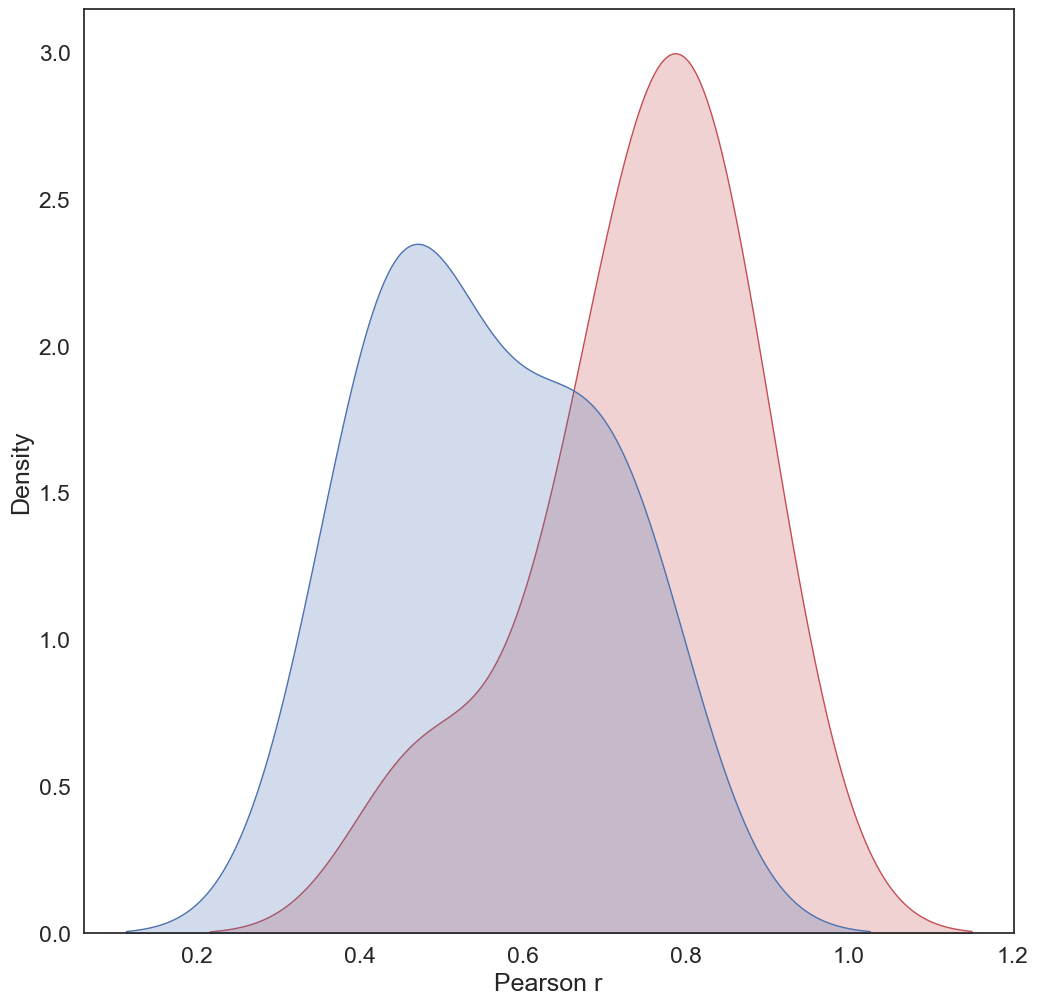

In [94]:
sns.set_theme(font_scale=1.5)
sns.set_style("white")
sns.kdeplot(res_df["FEP Correlation"],color="r",fill=True)
ax = sns.kdeplot(res_df["TI Correlation"],color="b",fill=True)
_ = ax.set(xlabel="Pearson r",ylabel="Density")

In [96]:
# Calculating the Cohen's d for RMSE
gb = big_df.groupby("Target")
res = []
for k,v in gb:
    res.append([k,mean_squared_error(v.Experimental_dG,v.FEP_dG),mean_squared_error(v.Experimental_dG,v.TI_dG)])
rmse_df = pd.DataFrame(res,columns=["Target","FEP RMSE","TI RMSE"])

delta = rmse_df["FEP RMSE"].values - rmse_df["TI RMSE"].values

effect_size = np.mean(delta)/np.std(delta)
print(effect_size)

d_to_probability(effect_size)



-1.0813375331578456


0.7703343832894614